In [1]:
"""
Created on Fri Jan 3 15:52 2019

@author: Soeren Brandt
"""

# import our modules
#import fra_expt

#import some generally useful modules
import numpy as np
import matplotlib.pyplot as plt
import scipy

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Helvetica', 'Arial']

In [2]:
import numpy as np
from matplotlib import rcParams
import matplotlib.pyplot as plt
import scipy
from sklearn import datasets, svm, metrics

from data.data_functions import (
        DataLoader,
        DerivTransform, 
        NormalizeTransform
)
from data.datasets import BinaryMixtures, COLOR_DICT
from data.experiment_parameters import (
        ExperimentFilter,
        Chamber, 
        Sensor, 
        InjectionTime, 
        InjectionRate, 
        InjectionVolume
)
from data.plot_functions import (
        plot_array_data, 
        get_gradient_colors,
        plot_regression,
)
from data.utils import train_test_split, sort_by_set

In [3]:
properties = ['Boiling Point', 'Flash Point', 'Viscosity', 'Vapor Pressure']
marker_dict = dict([('Pentane','o'), ('Hexane','s'), ('Heptane','D'), ('Octane','^'), ('Nonane','>'), ('Decane','v')])

labelsize = 13
ticksize = 12
legendsize = 12

#### Functions

In [4]:
from data.utils import create_label_for
from sklearn import datasets, svm, metrics
from sklearn.model_selection import GridSearchCV
    
unit = {"Vapor Pressure": " [kPa]",
        "Boiling Point": " [$^\circ$C]",
        "Flash Point": " [$^\circ$C]",
        "Viscosity": " [mPa$\cdot$s]"}

def predict_property(property_, train_set, train_derivs, kernel = 'rbf'):
    if property_ not in unit.keys():
        print('Property is ill-defined.')
        return
    
    # Change labels
    train_lbl = np.array(create_label_for(train_set, property_))
    
    # Perform SVR
    gridsearch = False

    if gridsearch == True:
        #------------------------------------------------------------#
        # SVR with gridsearch
        #------------------------------------------------------------#
        parameters = {'kernel':('linear', 'rbf'), 'C':(1e-10,1e-7,1e-5,1e-3,1,1e3,1e5,1e7,1e10), 'gamma':(1e-10,1e-7,1e-5,1e-3,1,1e3,1e5,1e7,1e10)}
        GS = svm.SVR()
        SVR = GridSearchCV(GS, parameters, cv=5)
    else:
        #------------------------------------------------------------#
        # SVR
        #------------------------------------------------------------#
        SVR = svm.SVR(C=1e4,gamma=1e1, kernel=kernel)

    SVR.fit(train_derivs, train_lbl)
    
    return SVR


def plot_property(ax, property_, SVR, test_set, test_derivs, train_set, train_derivs, label = 'Toluene prediction', color = 'r'):
    if property_ in ['Boiling Point', 'Flash Point']:
        adj_axes = 273.15
    elif property_ in ['Vapor Pressure', 'Viscosity']:
        adj_axes = 0
    else:
        print('Property is ill-defined.')
        return
    
    # Change labels
    train_lbl = np.array(create_label_for(train_set, property_))
    test_lbl = np.array(create_label_for(test_set, property_))
    
    # Calculate R^2 value
    predicted = SVR.predict(test_derivs)
    score = SVR.score(test_derivs, test_lbl)

    # Calculate RMS error
    actual = np.array(test_lbl).reshape(1,-1)
    predicted = np.array(predicted).reshape(1,-1)
    N = len(test_lbl)
    error = np.sqrt(np.sum((predicted-actual)**2)/N)
    
    ######## PLOT ########
    ax.set_xlabel('Actual '+property_+unit[property_], fontsize = labelsize)
    ax.set_ylabel('Predicted '+property_+unit[property_], fontsize = labelsize)
    ax.tick_params(direction='in', top = True, bottom = True, left = True, right = True, labelsize = ticksize)

    # plot line representing 1:1 correspondence
    ax.plot(np.linspace(np.min(np.append(train_lbl-adj_axes,0)),np.max(train_lbl-adj_axes),100),np.linspace(np.min(np.append(train_lbl-adj_axes,0)),np.max(train_lbl-adj_axes),100),'--',c='k',linewidth=1)
    
    if score > 0.5:
        # scatter predictions
        #ax.scatter(np.array(test_lbl-adj_axes),np.array(predicted-adj_axes),c=np.array([82/255., 157/255., 64/255.])*0.8,s=15, label = "Alkane prediction")
        for ind,lbl in enumerate([key for key,values in test_set.items() for value in values]):
            ax.scatter(np.array(test_lbl[ind]-adj_axes),np.array(predicted[0][ind]-adj_axes),color=np.array([82/255., 157/255., 64/255.])*0.8,marker=marker_dict[lbl],s=15, label = "Alkane prediction")

        # label
        ax.text(0.065,0.97, "$R^2$ = "+str(round(score,3)) + "\nRMSE = "+str(round(error,2)), fontsize=labelsize, verticalalignment='top', transform = ax.transAxes)
    else:
        #ax.set_xlabel('Actual '+property_+unit[property_], fontsize = labelsize)
        fitted = SVR.predict(train_derivs)
        
        # scatter predictions
        ax.scatter(np.array(test_lbl-adj_axes),np.array(predicted-adj_axes),c=color, marker='o',s=15, label = label)

        # scatter training
        #ax.scatter(np.array(train_lbl-adj_axes),np.array(fitted-adj_axes),c='None', marker='s',s=20,edgecolors=(0, 0, 0), alpha=0.3,linewidths=0.5, label = "Alkane training") # previous edgecolor = (68/255., 114/255., 196/255.) with alpha = None
        for ind,lbl in enumerate([key for key,values in train_set.items() for value in values]):
            ax.scatter(np.array(train_lbl[ind]-adj_axes),np.array(fitted[ind]-adj_axes),c='None', marker=marker_dict[lbl],s=20,edgecolors=(0, 0, 0), alpha=0.3,linewidths=0.5, label = "Alkane training")

        # label
        ax.text(0.065,0.955, "RMSE = "+str(round(np.sqrt(np.sum((predicted-actual)**2)/N),2)), fontsize=labelsize, verticalalignment='top', transform = ax.transAxes)
        print(property_ + ': ' + str(np.mean(predicted-adj_axes).round(2)) + ' ± ' + str(round(np.sqrt(np.sum((predicted-actual)**2)/N),2)) + unit[property_])

    #plt.legend(loc="lower right", fontsize = 12, markerscale = 1.5)
    plt.tight_layout()
    
    #fig = plt.gcf()
    #plt.close()
    
    #return fig
    
def sig(x,n=2): # round to significant figures
    from math import log10, floor
    return round(x, n-1-int(floor(log10(abs(x)))))

def plot_feature_weight(SVR, property_, train_derivs = [], test_derivs = [], ax = plt):
    if train_derivs:
        max_ = np.max(train_derivs, axis = 0)
        min_ = np.min(train_derivs, axis = 0)
        
        ax.fill_between(np.linspace(0,len(max_)-1,len(max_)),max_,min_, color = 'k', alpha=0.1)
    if test_derivs:
        max_T = np.max(toluene_derivs, axis = 0)
        min_T = np.min(toluene_derivs, axis = 0)
        
        ax.fill_between(np.linspace(0,len(max_T)-1,len(max_T)),max_T,min_T, color = 'r', alpha=0.1)
    
    prod = np.matmul(SVR[property_].dual_coef_,SVR[property_].support_vectors_)
    weights = prod.T/np.sqrt(np.sum(prod.T**2))
    
    ax.set_xlabel('Time (s)', fontsize = labelsize)
    
    if np.max(weights) >= np.abs(np.min(weights)):
        ax.plot(weights);
        ax.set_ylabel('Feature weight$^*$', fontsize = labelsize)
    else:
        ax.plot(-weights);
        ax.set_ylabel('-Feature weight$^*$', fontsize = labelsize)

## Known analytes

In [28]:
from data.datasets import PureCompounds
from data.data_functions import DataLoader, PhaseTransform, DerivTransform, NormalizeTransform, NormalizePhaseTransform, SNIFFING_PATH
from data.utils import train_test_split

filters = ExperimentFilter(Chamber.TALL, Sensor.SM30, InjectionTime(15.0), InjectionRate(6.0), InjectionVolume(1.3))
exp_set = PureCompounds(['Pentane', 'Hexane','Heptane','Octane','Nonane','Decane'], filters=filters)
train_set, test_set = train_test_split(exp_set, test_size = 1./5, seed=0)

exp_derivs, _ = DataLoader(exp_set, transforms=[DerivTransform, NormalizeTransform]).load()
train_derivs, train_lbl, test_derivs, test_lbl = sort_by_set(exp_derivs, train_set, test_set)

Loading experimental data
Pentane (1/6): [===================0] 100% complete
Hexane (2/6): [===================0] 100% complete
Heptane (3/6): [===================0] 100% complete
Octane (4/6): [===================0] 100% complete
Nonane (5/6): [===================0] 100% complete
Decane (6/6): [===================0] 100% complete
Length of experimental set loaded: 38


## Unknown analyte

In [6]:
toluene_set = PureCompounds(['Toluene'], filters=filters)

exp_derivs_2, _ = DataLoader(toluene_set, transforms=[DerivTransform, NormalizeTransform]).load()
toluene_derivs, _ = sort_by_set(exp_derivs_2, toluene_set)

Loading experimental data
Toluene (1/1): [===================0] 100% complete
Length of experimental set loaded: 7


# Create Plot

Create SVRs

In [7]:
SVR = {}
#figA = {}

for property_ in properties:
    SVR[property_] = predict_property(property_, train_set, train_derivs);
    #figA[property_] = plot_property(property_, SVR[property_], test_set, test_derivs, train_set, train_derivs);

Boiling Point: 116.49 ± 9.44 [$^\circ$C]
Flash Point: 5.78 ± 4.82 [$^\circ$C]
Viscosity: 0.47 ± 0.09 [mPa$\cdot$s]
Vapor Pressure: 11.68 ± 9.0 [kPa]


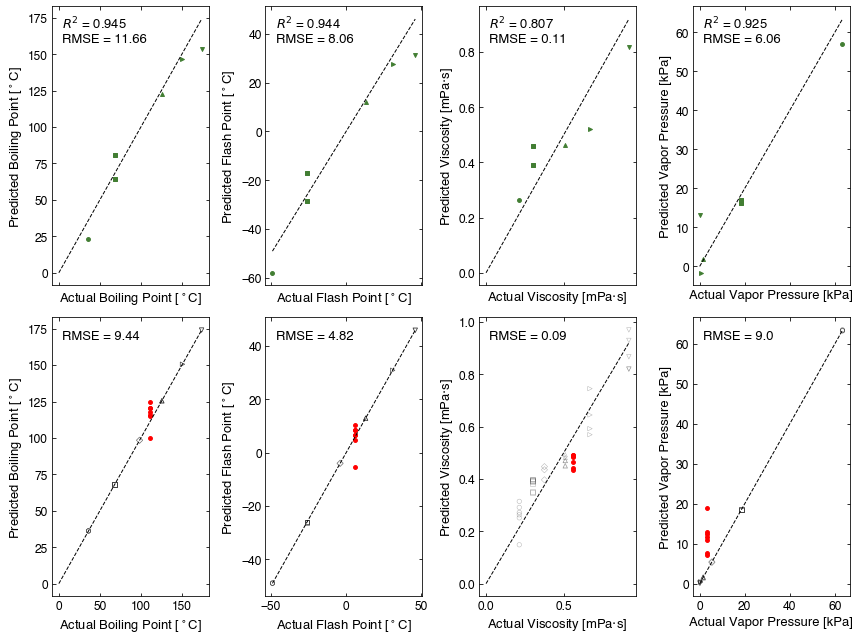

In [8]:
fig, ax = plt.subplots(2, len(SVR), sharex='col', sharey=False);
fig.set_figwidth(12)
fig.set_figheight(9)

for a, property_ in enumerate(properties):
    plot_property(ax[0,a], property_, SVR[property_], test_set, test_derivs, train_set, train_derivs);
    plot_property(ax[1,a], property_, SVR[property_], toluene_set, toluene_derivs, train_set, train_derivs);

for a in ax.flatten():
    if a.get_legend() != None:
        a.get_legend().remove()
    
#ax[0,0].legend(loc="lower right", fontsize = legendsize, markerscale = 1.5);
#ax[1,0].legend(loc="lower right", fontsize = legendsize, markerscale = 1.5);

In [42]:
from itertools import cycle
import pandas as pd

csv_units = {"Vapor Pressure": " [kPa]",
        "Boiling Point": " [K]",
        "Flash Point": " [K]",
        "Viscosity": " [mPa s]"}

train_data = pd.DataFrame(sum([
    list(zip(cycle([chem]), exps)) for chem, exps in train_set.items()
], []), columns=["Compound", "Experiment_ID"])

for property_ in properties:
    train_data[f"{property_} {csv_units[property_]}"] = np.array(create_label_for(train_set, property_))
    train_data[f"predicted {property_}"] = SVR[property_].predict(train_derivs)

combined_test_set = {**test_set, **toluene_set}
test_data = pd.DataFrame(sum([
    list(zip(cycle([chem]), exps)) for chem, exps in combined_test_set.items()
], []), columns=["Compound", "Experiment_ID"])

for property_ in properties:
    test_data[f"{property_} {csv_units[property_]}"] = np.array(create_label_for(combined_test_set, property_))
    test_data[f"predicted {property_}"] = SVR[property_].predict(test_derivs+toluene_derivs)

train_data.to_csv("property_prediction_training_data.csv")
test_data.to_csv("property_prediction_test_data.csv")


Boiling Point: 116.49 ± 9.44 [$^\circ$C]
Flash Point: 5.78 ± 4.82 [$^\circ$C]
Viscosity: 0.47 ± 0.09 [mPa$\cdot$s]
Vapor Pressure: 11.68 ± 9.0 [kPa]


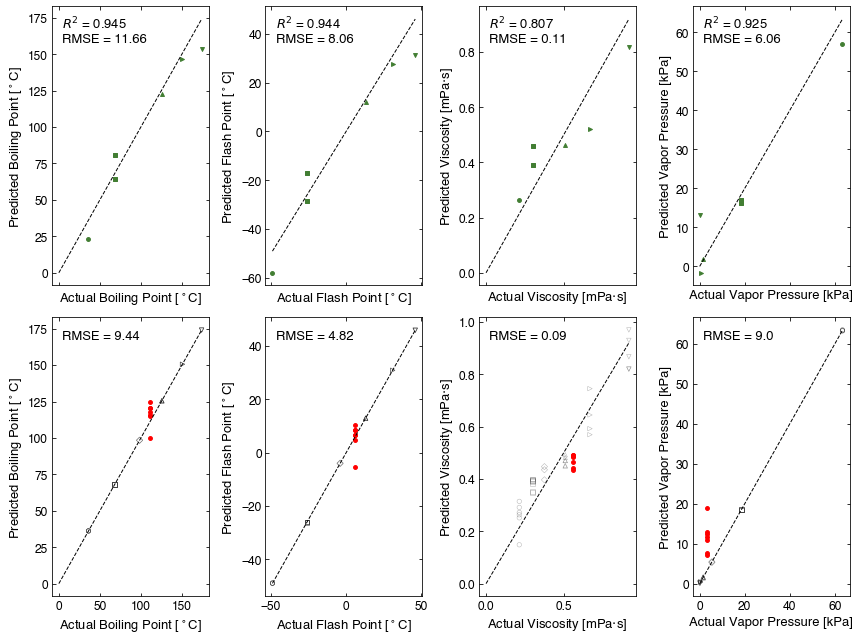

In [8]:
fig, ax = plt.subplots(2, len(SVR), sharex='col', sharey=False);
fig.set_figwidth(12)
fig.set_figheight(9)

for a, property_ in enumerate(properties):
    plot_property(ax[0,a], property_, SVR[property_], test_set, test_derivs, train_set, train_derivs);
    plot_property(ax[1,a], property_, SVR[property_], toluene_set, toluene_derivs, train_set, train_derivs);

for a in ax.flatten():
    if a.get_legend() != None:
        a.get_legend().remove()
    
#ax[0,0].legend(loc="lower right", fontsize = legendsize, markerscale = 1.5);
#ax[1,0].legend(loc="lower right", fontsize = legendsize, markerscale = 1.5);

Boiling Point: 115.51 ± 7.64 [$^\circ$C]
Flash Point: 5.53 ± 3.59 [$^\circ$C]
Viscosity: 0.52 ± 0.05 [mPa$\cdot$s]
Vapor Pressure: 13.21 ± 10.58 [kPa]


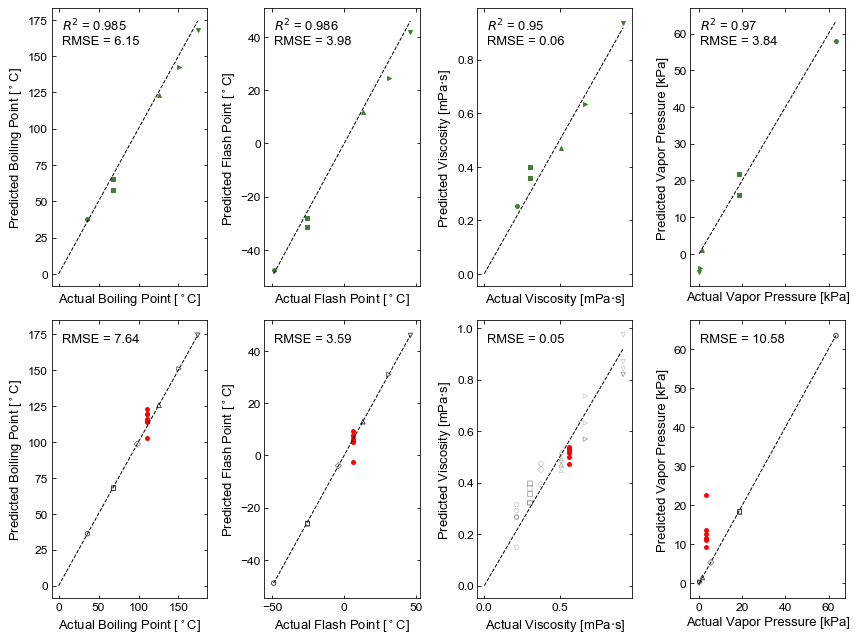

In [9]:
fig, ax = plt.subplots(2, len(SVR), sharex='col', sharey=False);
fig.set_figwidth(12)
fig.set_figheight(9)

for a, property_ in enumerate(properties):
    plot_property(ax[0,a], property_, SVR[property_], test_set, test_derivs, train_set, train_derivs);
    plot_property(ax[1,a], property_, SVR[property_], toluene_set, toluene_derivs, train_set, train_derivs);

for a in ax.flatten():
    if a.get_legend() != None:
        a.get_legend().remove()
    
#ax[0,0].legend(loc="lower right", fontsize = legendsize, markerscale = 1.5);
#ax[1,0].legend(loc="lower right", fontsize = legendsize, markerscale = 1.5);

# Final Plot

Boiling Point: 115.51 ± 7.64 [$^\circ$C]


NameError: name 'linSVR' is not defined

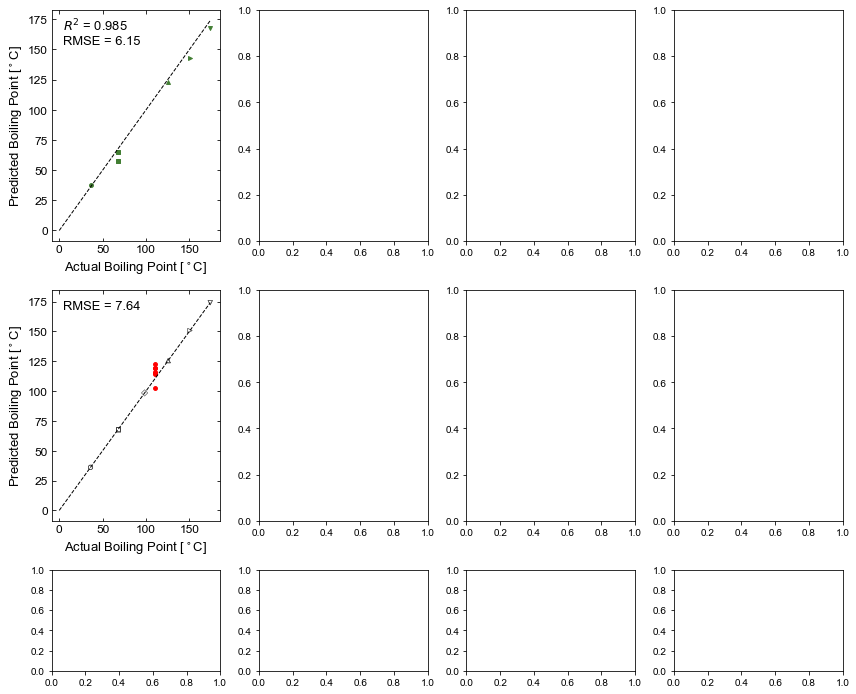

In [11]:
from matplotlib import gridspec
widths = [3, 3, 3, 3]
heights = [4, 4, 1.75]
fig = plt.figure(figsize=(sum(widths),sum(heights))) 
gs = gridspec.GridSpec(ncols=4, nrows=3, width_ratios=widths,
                          height_ratios=heights)

# divide figure into suplots
axA = [fig.add_subplot(gs[0, c]) for c in range(0,4)]
axB = [fig.add_subplot(gs[1, c]) for c in range(0,4)]
axC = [fig.add_subplot(gs[-1, c]) for c in range(0,4)]

# add figures to sections
for a, property_ in enumerate(properties):
    plot_property(axA[a], property_, SVR[property_], test_set, test_derivs, train_set, train_derivs);
    plot_property(axB[a], property_, SVR[property_], toluene_set, toluene_derivs, train_set, train_derivs);
    plot_feature_weight(linSVR, property_, train_derivs = train_derivs, test_derivs = toluene_derivs, ax = axC[a])
    
# remove legends from all plots
for a in axA+axB+axC:
    if a.get_legend() != None:
        a.get_legend().remove()

# add legends to the first column
#axA[0].legend(loc="lower center", fontsize = legendsize, markerscale = 1.5, handlelength=0.5);
#axB[0].legend(loc="lower center", fontsize = legendsize, markerscale = 1.5, handlelength=0.5);

# change x-lim in last row
maxLim = [0,0]
for a in axC:
    if a.get_ylim()[0] < maxLim[0]:
        maxLim[0] = a.get_ylim()[0]
    if a.get_ylim()[1] > maxLim [1]:
        maxLim[1] = a.get_ylim()[1]
for a in axC:
    a.set_ylim(maxLim)
    a.set_xlim([0,600])
#fig.savefig('../../../../../Macintosh HD/Users/Soren/Desktop/Figure-3 JN v2.svg', format='svg', dpi=1200)

Supplementary figure for linear kernel

In [9]:
linSVR = {}
#figA = {}

for property_ in properties:
    linSVR[property_] = predict_property(property_, train_set, train_derivs, kernel = 'linear');
    #figA[property_] = plot_property(property_, SVR[property_], test_set, test_derivs, train_set, train_derivs);

Boiling Point: 64.44 ± 52.04 [$^\circ$C]
Flash Point: -28.97 ± 38.22 [$^\circ$C]
Viscosity: 0.37 ± 0.24 [mPa$\cdot$s]
Vapor Pressure: 33.75 ± 32.85 [kPa]


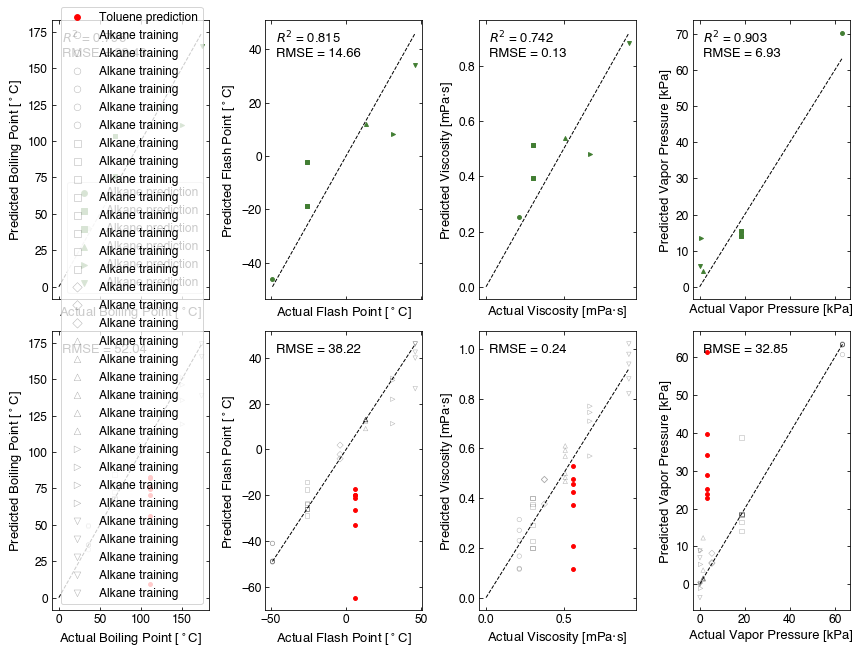

In [10]:
fig, ax = plt.subplots(2, len(SVR), sharex='col', sharey=False);
fig.set_figwidth(12)
fig.set_figheight(9)

for a, property_ in enumerate(properties):
    plot_property(ax[0,a], property_, linSVR[property_], test_set, test_derivs, train_set, train_derivs);
    plot_property(ax[1,a], property_, linSVR[property_], toluene_set, toluene_derivs, train_set, train_derivs);

for a in ax.flatten():
    if a.get_legend() != None:
        a.get_legend().remove()
    
ax[0,0].legend(loc="lower right", fontsize = legendsize, markerscale = 1.5);
ax[1,0].legend(loc="lower right", fontsize = legendsize, markerscale = 1.5);

Boiling Point: 65.58 ± 48.71 [$^\circ$C]
Flash Point: -29.45 ± 37.31 [$^\circ$C]
Viscosity: 0.37 ± 0.21 [mPa$\cdot$s]
Vapor Pressure: 31.28 ± 28.99 [kPa]


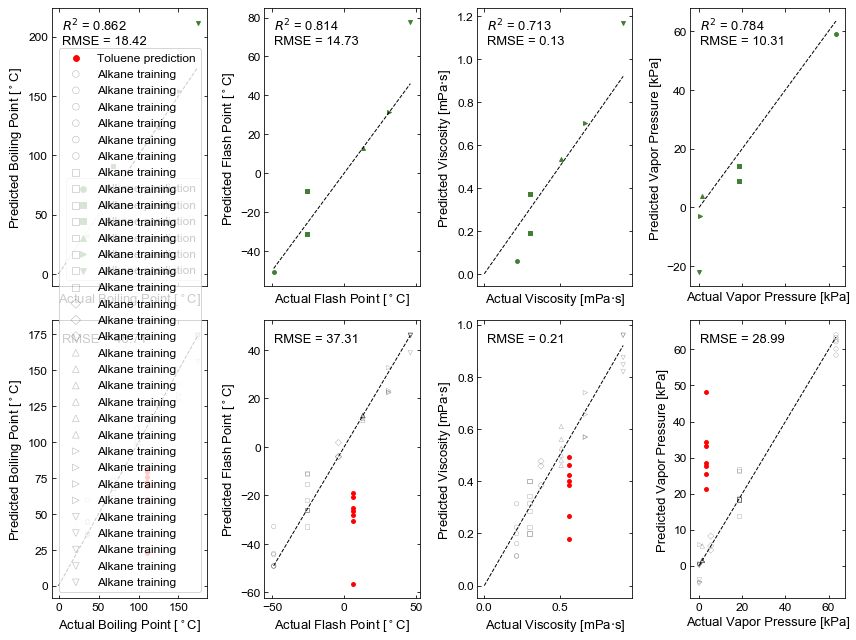

In [ ]:
fig, ax = plt.subplots(2, len(SVR), sharex='col', sharey=False);
fig.set_figwidth(12)
fig.set_figheight(9)

for a, property_ in enumerate(properties):
    plot_property(ax[0,a], property_, linSVR[property_], test_set, test_derivs, train_set, train_derivs);
    plot_property(ax[1,a], property_, linSVR[property_], toluene_set, toluene_derivs, train_set, train_derivs);

for a in ax.flatten():
    if a.get_legend() != None:
        a.get_legend().remove()
    
ax[0,0].legend(loc="lower right", fontsize = legendsize, markerscale = 1.5);
ax[1,0].legend(loc="lower right", fontsize = legendsize, markerscale = 1.5);

##### Supplementary feature weights

In [11]:
from collections import OrderedDict

all_derivs = dict([(key,value) for key,value in exp_derivs.items()])
for key, value in exp_derivs_2.items():
    all_derivs[key] = value
all_set = OrderedDict([(key,value) for key,value in exp_set.items()])
for key, value in toluene_set.items():
    all_set[key] = value

In [12]:
def plot_array_data(exp_set, input_data, xlim, ylim=None, color_dict = None, legend=True, ax=None, linewidth = None, linestyle = '-', label = True):
    if ax == None:
        fig, ax = plt.subplots()
        
    for chem in exp_set:    
        nums = exp_set[chem]
        data = [input_data[n] for n in nums]

        # calculate average
        avg = np.average(data, axis = 0)
        std = np.std(data, axis = 0)
        
        try:
            ax.plot(np.linspace(xlim[0],xlim[1],len(avg)),avg, label = chem, linestyle = linestyle, linewidth = linewidth, color = color_dict[chem])
            ax.fill_between(np.linspace(xlim[0],xlim[1],len(avg)),np.array(avg) - np.array(std),np.array(avg) + np.array(std), color = color_dict[chem], alpha=0.1)
        except:
            ax.plot(np.linspace(xlim[0],xlim[1],len(avg)),avg, label = chem, color = None)
            ax.fill_between(np.linspace(xlim[0],xlim[1],len(avg)),np.array(avg) - np.array(std),np.array(avg) + np.array(std), alpha=0.1)
        if legend:
            if len(exp_set) > 8:
                ax.legend(loc='upper right', bbox_to_anchor=(1.015, 1.02), ncol=2, frameon=False, shadow=False, fontsize=legendsize)
            else:
                ax.legend(loc='upper right', bbox_to_anchor=(1.015, 1.02), ncol=1, frameon=False, shadow=False, fontsize=legendsize)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
    if label == True:
        if xlim[0] == 0:
            ax.set_xlabel("Time (s)", fontsize=labelsize);
            ax.set_ylabel("Phase derivative (a.u.)", fontsize=labelsize)
        else:
            ax.set_xlabel("Wavelength (nm)", fontsize=labelsize)
            ax.set_ylabel("$\Delta I$ (a.u.)", fontsize=labelsize)
        ax.tick_params(labelsize=ticksize)
    else:
        ax.set_xticks = []

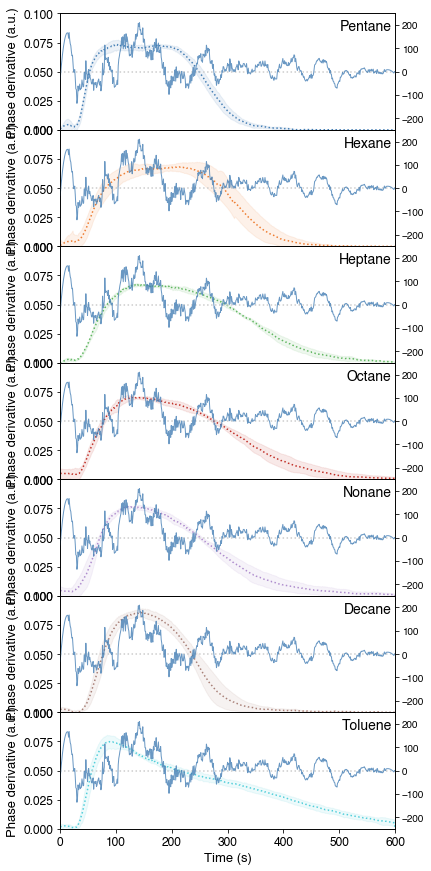

In [16]:
from data.datasets import COLOR_DICT as color_dict

fig,ax = plt.subplots(ncols = 1, nrows = len(all_set), sharex = True)
fig.set_figheight(15)
fig.subplots_adjust(hspace=0)

property_ = 'Boiling Point'

for n,chem in enumerate(all_set):    
    ax2 = ax[n].twinx()
    ax2.set_ylim([-250,250])
    ax2.set_xlim([-25,625])
    ax2.plot([0,650],[0,0],color=(0.8,0.8,0.8),linestyle=':') # plot line zero
    ax2.plot(linSVR[property_].coef_[0], color=color_dict['Pentane'], alpha=0.8, linewidth=1)
    ax[n].text(0.99,0.95, chem, fontsize=14, verticalalignment='top', horizontalalignment = 'right', transform = ax[n].transAxes)
    
    subset = OrderedDict([list(all_set.items())[n]])
    plot_array_data(subset, all_derivs, [0,600], ylim=[0,0.1], color_dict = color_dict, ax=ax[n], linestyle = ':', linewidth = 1.5)
    ax[n].get_legend().remove()

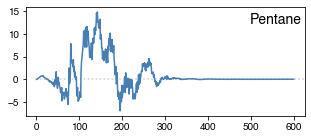

In [19]:
property_ = properties[0]
p = 0

chem = 'Pentane'
n = 0

subset = OrderedDict([list(all_set.items())[n]])
data = [all_derivs[m] for m in list(subset.values())[0]]
avg = np.average(data, axis = 0) # calculate average

fig,ax = plt.subplots()

ax.set_xlim([-25,625])
ax.plot([0,625],[0,0],color=(0.8,0.8,0.8),linestyle=':') # plot line zero
ax.plot(linSVR[property_].coef_[0]*avg, color=color_dict[chem])
ax.text(0.99,0.95, chem, fontsize=14, verticalalignment='top', horizontalalignment = 'right', transform = ax.transAxes)
#ax[n].set_ylim([-0.4,1])

ax2.set_xlim([-25,625])
ax2.plot([0,625],[0,0],color=(0.8,0.8,0.8),linestyle=':') # plot line zero
if chem in ['Pentane','Hexane','Heptane']:
    ax2.scatter(np.linspace(0,600,600),linSVR[property_].coef_[0]*avg, s=0.5, color=color_dict[chem], label = chem)
elif chem in ['Toluene']:
    ax2.plot(linSVR[property_].coef_[0]*avg, color=color_dict[chem], label = chem)
ax2.legend(loc = 'lower right')

fig.set_size_inches([5,2])
# coloring in certain regions e.g. (BP,FP) [250, 350], (VP) [50, 100], (3) , and (concentration change in) [50, 250]
#ax.fill_between([50, 250],[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2, color = (0.7, 0.7, 0.7), alpha=0.1)

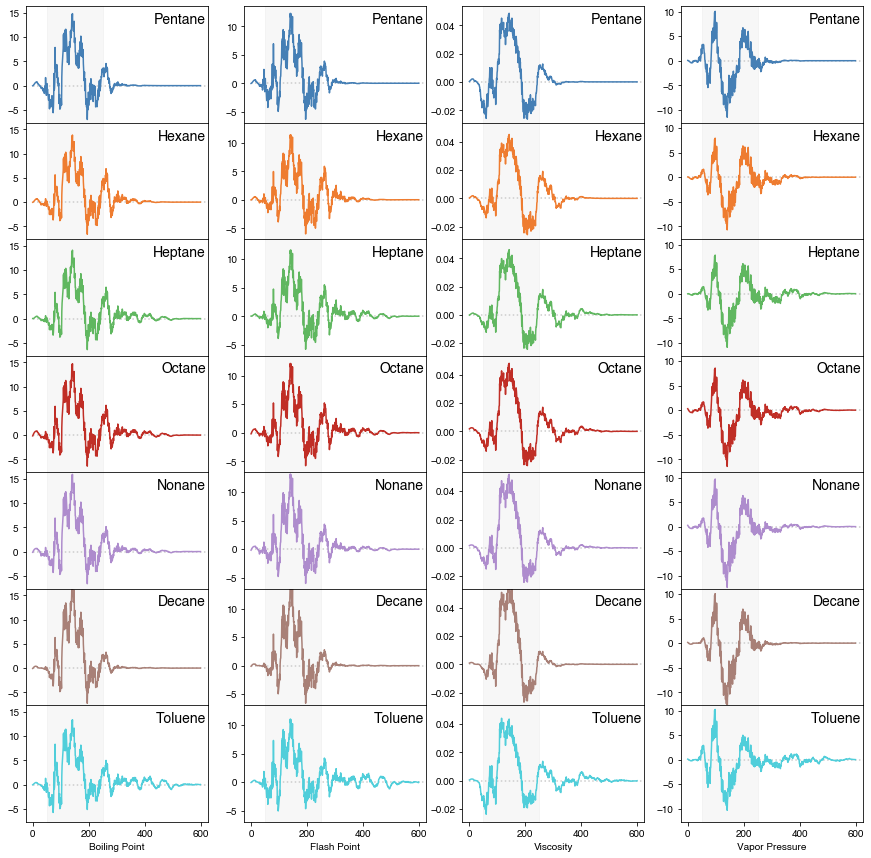

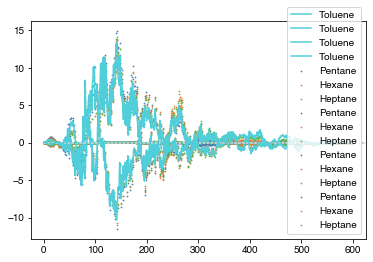

In [25]:
# plot multiplied feature coef_ and average phase derivative
fig,axes = plt.subplots(ncols = 4, nrows = len(all_set), sharex = True, sharey='col')
fig.set_figheight(15)
fig.set_figwidth(15)
fig.subplots_adjust(hspace=0)

fig2, ax2 = plt.subplots()

for p,property_ in enumerate(properties):
    for n,chem in enumerate(all_set):
        subset = OrderedDict([list(all_set.items())[n]])
        data = [all_derivs[m] for m in list(subset.values())[0]]
        avg = np.average(data, axis = 0) # calculate average
        
        ax = axes[n,p]

        ax.set_xlim([-25,625])
        if n==0:
            values = linSVR[property_].coef_[0]*avg
            ax.set_ylim([min(values)*1.1, max(values)*1.1])
        ax.plot([0,625],[0,0],color=(0.8,0.8,0.8),linestyle=':') # plot line zero
        ax.plot(linSVR[property_].coef_[0]*avg, color=color_dict[chem])
        ax.text(0.99,0.95, chem, fontsize=14, verticalalignment='top', horizontalalignment = 'right', transform = ax.transAxes)
        #ax[n].set_ylim([-0.4,1])

        ax2.set_xlim([-25,625])
        ax2.plot([0,625],[0,0],color=(0.8,0.8,0.8),linestyle=':') # plot line zero
        if chem in ['Pentane','Hexane','Heptane']:
            ax2.scatter(np.linspace(0,600,600),linSVR[property_].coef_[0]*avg, s=0.5, color=color_dict[chem], label = chem)
        elif chem in ['Toluene']:
            ax2.plot(linSVR[property_].coef_[0]*avg, color=color_dict[chem], label = chem)
        ax2.legend(loc = 'lower right')
        
        # coloring in certain regions e.g. (BP,FP) [250, 350], (VP) [50, 100], (3) , and (concentration change in) [50, 250]
        ax.fill_between([50, 250],[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2, color = (0.7, 0.7, 0.7), alpha=0.1)
    
    ax.set_xlabel(property_)
#fig.savefig('Feature Weights - all.svg', dpi=1200)

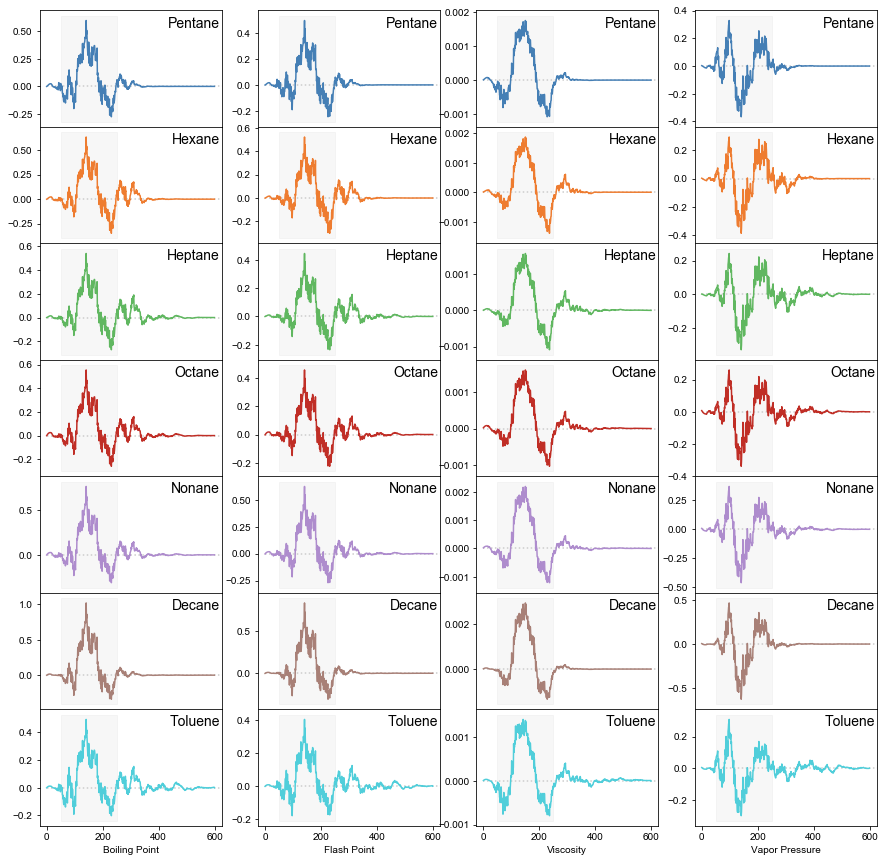

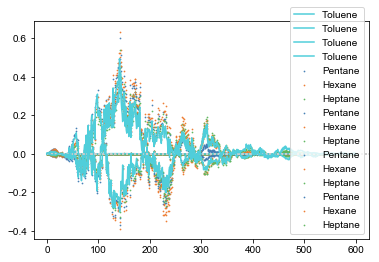

In [ ]:
# plot multiplied feature coef_ and average phase derivative
fig,axes = plt.subplots(ncols = 4, nrows = len(all_set), sharex = True, sharey='col')
fig.set_figheight(15)
fig.set_figwidth(15)
fig.subplots_adjust(hspace=0)

fig2, ax2 = plt.subplots()

for p,property_ in enumerate(properties):
    for n,chem in enumerate(all_set):
        subset = OrderedDict([all_set.items()[n]])
        data = [all_derivs[m] for m in subset.values()[0]]
        avg = np.average(data, axis = 0) # calculate average
        
        ax = axes[n,p]

        ax.set_xlim([-25,625])
        ax.plot([0,625],[0,0],color=(0.8,0.8,0.8),linestyle=':') # plot line zero
        ax.plot(linSVR[property_].coef_[0]*avg, color=color_dict[chem])
        ax.text(0.99,0.95, chem, fontsize=14, verticalalignment='top', horizontalalignment = 'right', transform = ax.transAxes)
        #ax[n].set_ylim([-0.4,1])

        ax2.set_xlim([-25,625])
        ax2.plot([0,625],[0,0],color=(0.8,0.8,0.8),linestyle=':') # plot line zero
        if chem in ['Pentane','Hexane','Heptane']:
            ax2.scatter(np.linspace(0,600,600),linSVR[property_].coef_[0]*avg, s=0.5, color=color_dict[chem], label = chem)
        elif chem in ['Toluene']:
            ax2.plot(linSVR[property_].coef_[0]*avg, color=color_dict[chem], label = chem)
        ax2.legend(loc = 'lower right')
        
        # coloring in certain regions e.g. (BP,FP) [250, 350], (VP) [50, 100], (3) , and (concentration change in) [50, 250]
        ax.fill_between([50, 250],[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2, color = (0.7, 0.7, 0.7), alpha=0.1)
    
    ax.set_xlabel(property_)
fig.savefig('../../../../../Macintosh HD/Users/Soren/Desktop/Feature Weights - all.svg', dpi=1200)

## Feature Importance
for supplement potentially

In [19]:
linSVR = {}
#figA = {}

for property_ in properties:
    linSVR[property_] = predict_property(property_, train_set, train_derivs, kernel='linear');
    #figA[property_] = plot_property(property_, SVR[property_], test_set, test_derivs, train_set, train_derivs);

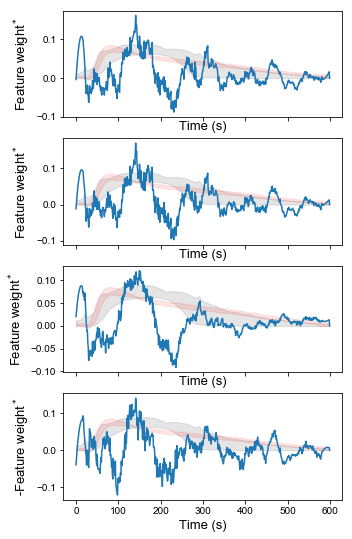

In [20]:
fig, ax = plt.subplots(len(properties),1, sharex='col', sharey=False);
fig.set_figwidth(5)
fig.set_figheight(9)

for n,property_ in enumerate(properties):
    plot_feature_weight(linSVR, property_, train_derivs = train_derivs, test_derivs = toluene_derivs, ax = ax[n])

In [21]:
# Plot using linear kernel

#fig, ax = plt.subplots(2, len(SVR), sharex='col', sharey=False);
#fig.set_figwidth(12)
#fig.set_figheight(9)
#
#for a, property_ in enumerate(properties):
#    plot_property(ax[0,a], property_, linSVR[property_], test_set, test_derivs, train_set, train_derivs);
#    plot_property(ax[1,a], property_, linSVR[property_], toluene_set, toluene_derivs, train_set, train_derivs);
#
#for a in ax.flatten():
#    if a.get_legend() != None:
#        a.get_legend().remove()
#    
#ax[0,0].legend(loc="lower right", fontsize = 12, markerscale = 1.5);
#ax[1,0].legend(loc="lower right", fontsize = 12, markerscale = 1.5);

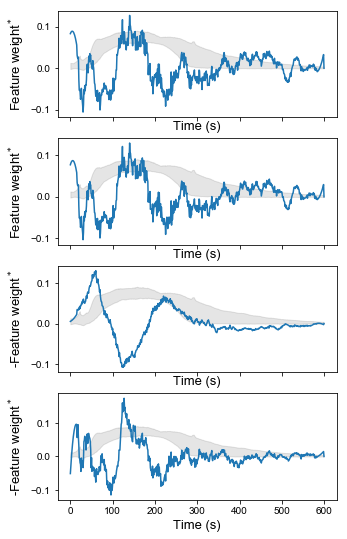

In [22]:
# Feature "weights" using RBF kernel (do not work the same way as in linear)

fig, ax = plt.subplots(len(properties),1, sharex='col', sharey=False);
fig.set_figwidth(5)
fig.set_figheight(9)

for n,property_ in enumerate(properties):
    plot_feature_weight(SVR, property_, train_derivs = train_derivs, ax = ax[n])

## Polar chemicals

In [23]:
from datasets import pure_compounds, tall_Cuvettes, SM30_Sensors, injection_Time, injection_Rate, injection_Volume
from datasets import train_test_split
#exp_set = pure_compounds(['Pentane', 'Hexane','Heptane','Octane','Nonane','Decane', 'Toluene'], in_ = tall_Cuvettes(), with_ = SM30_Sensors(), and_a = injection_Time([15.0]), and_b = injection_Rate(6.0), and_c = injection_Volume([1.3]))
#train_set = train_set #pure_compounds(['Pentane', 'Hexane','Heptane', 'Octane', 'Nonane','Decane'], in_ = tall_Cuvettes(), with_ = SM30_Sensors(), and_a = injection_Time([15.0]), and_b = injection_Rate(6.0), and_c = injection_Volume([1.3]))
polar_set = pure_compounds(['Ethanol','Acetone','Acetonitrile'], in_ = tall_Cuvettes(), with_ = SM30_Sensors(), and_a = injection_Time([15.0]), and_b = injection_Rate(6.0), and_c = injection_Volume([1.3]))

In [24]:
from data_functions import load_set_from_CSV
exp_derivs, exp_num_name, m = load_set_from_CSV(polar_set)

from datasets import sort_by_set
polar_derivs, polar_lbl = sort_by_set(exp_derivs, polar_set)

Loading experimental data 
Ethanol: [===================0] 100%   1/3 complete
Acetone: [===================0] 100%   2/3 complete
Acetonitrile: [===================0] 100%   3/3 complete
Length of experimental set loaded: 23


Boiling Point: 105.39 ± 27.53 [$^\circ$C]
Boiling Point: 80.29 ± 36.17 [$^\circ$C]
Boiling Point: 97.25 ± 16.88 [$^\circ$C]
Flash Point: -2.04 ± 16.31 [$^\circ$C]
Flash Point: -18.87 ± 18.27 [$^\circ$C]
Flash Point: -6.44 ± 9.42 [$^\circ$C]
Viscosity: 0.47 ± 0.63 [mPa$\cdot$s]
Viscosity: 0.37 ± 0.11 [mPa$\cdot$s]
Viscosity: 0.43 ± 0.1 [mPa$\cdot$s]
Vapor Pressure: 16.08 ± 9.12 [kPa]
Vapor Pressure: 29.23 ± 15.46 [kPa]
Vapor Pressure: 13.97 ± 4.24 [kPa]


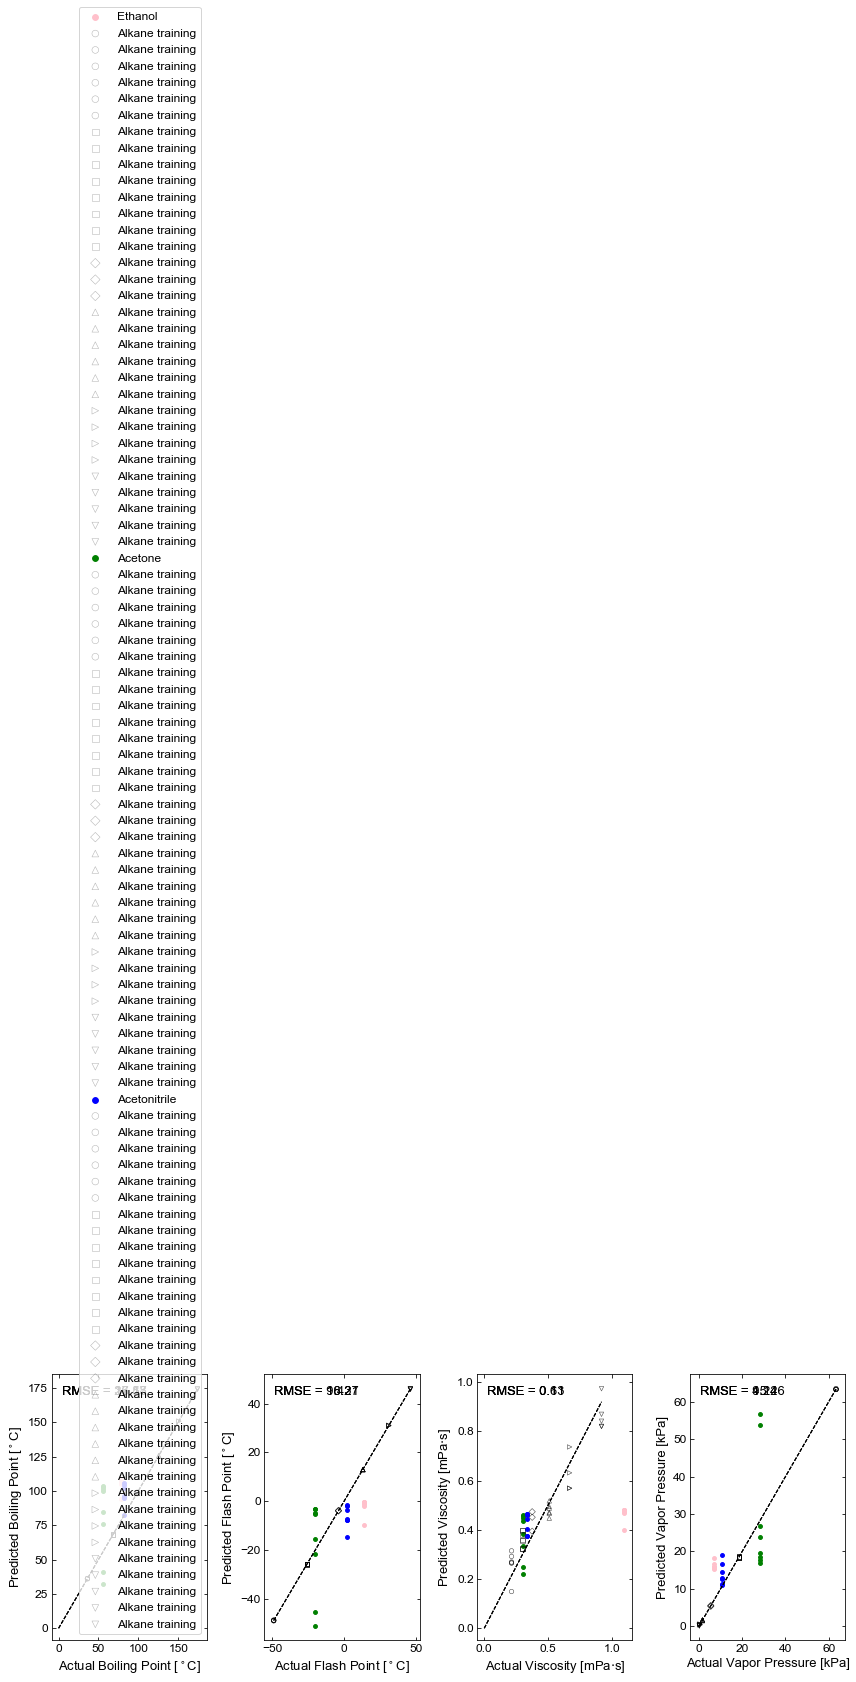

In [40]:
fig, ax = plt.subplots(1, len(SVR), sharex='col', sharey=False);
fig.set_figwidth(12)
fig.set_figheight(4.5)

colr = {'Ethanol': 'pink', 'Acetone': 'green', 'Acetonitrile': 'blue'}

for a, property_ in enumerate(properties):
    #plot_property(ax[0,a], property_, SVR[property_], test_set, test_derivs, train_set, train_derivs);
    #plot_property(ax[1,a], property_, SVR[property_], polar_set, polar_derivs, train_set, train_derivs);
    for chem in polar_set:
        sub_polar = {chem:polar_set[chem]}
        sub_derivs = list(np.array(polar_derivs)[np.where(chem == np.array(polar_lbl))])
        plot_property(ax[a], property_, SVR[property_], sub_polar, sub_derivs, train_set, train_derivs, label = chem, color = colr[chem]);

for a in ax.flatten():
    if a.get_legend() != None:
        a.get_legend().remove()
    
#ax[0,0].legend(loc="lower right", fontsize = 12, markerscale = 1.5);
ax[0].legend(loc="lower right", fontsize = 12, markerscale = 1.5);

#fig.savefig('../../../../../Macintosh HD/Users/Soren/Desktop/Predicting physical procerties - EtOH, Acetone, Acetonitrile.svg', dpi=1200)

## Concentration profiles vs time

In [26]:
"""
Created on Fri Feb 10 22:07 2019

@author: Soeren Brandt
"""

# import our modules
#import fra_expt

#import some generally useful modules
import numpy as np
import matplotlib.pyplot as plt
import scipy

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Helvetica', 'Arial']

In [27]:
# Injection
Injection_start_t = 15.0 #s
Injection_rate = 6.0 #mL/min
Injection_volume = 1.3 #mL

# Chemical: Pentane
constants = "Hexane"
adsorption_parameters_for = "Pentane"

# Sensor
sensor_pore_radius = 7.5 #nm
sensor_separation_distance = 8 #cm


from matplotlib.transforms import Bbox

def plot_adsorption(chems, exp_set, exp_data, color_dict = None, ax = None):
    if ax == None:
        fig,ax = plt.subplots()
    else:
        fig = plt.gcf()
        
    for n,chem in enumerate(chems):
        try:
            isotherm_film_height = get_isotherm_for(chem)
        except:
            isotherm_film_height = calculate_isotherm_for(chem, volume = 1.3, rate = 6, at = 15, separation = 8, sensor = 'SM30')
        
        try:
            ax.plot(np.linspace(0,1,600),isotherm_film_height(np.linspace(0,max(isotherm_film_height.x),600)), 
                label = chem, linestyle = '-', linewidth = None, color = color_dict[chem])

            # add inseat
            bb_data = Bbox.from_bounds(0.25*n, 0.75, 0.2, 0.25)
            disp_coords = ax.transData.transform(bb_data)
            pos = Bbox(fig.transFigure.inverted().transform(disp_coords))

            # plot average phase deriv
            ax2 = fig.add_axes(pos)
            nums = exp_set[chem]
            data = [exp_data[n] for n in nums]
            avg = np.average(data, axis = 0)

            ax2.plot(avg[:-150], color = color_dict[chem]) #'k')
            ax2.set_xticks([])
            ax2.set_yticks([])
            ax2.set_xlabel(chem, color = color_dict[chem], fontsize = ticksize*0.9)

            # adjust sub_axes
            #for axis in ['top','bottom','left','right']:
            #    ax2.spines[axis].set_linewidth(1.5)
            #    #ax2.spines[axis].set_color(color_dict[chem])
        except:
            isotherm_film_height
            ax.plot(np.linspace(0,1,600),isotherm_film_height(np.linspace(0,max(isotherm_film_height.x),600)))
        
    # adjust plot
    ax.set_xlabel("Vapor concentration p/$p_0$", fontsize=labelsize)
    ax.set_ylabel("Adsorbed film heigh h/$h_c$", fontsize=labelsize)
    ax.tick_params(labelsize=ticksize)
    
    try:
        return fig
    except:
        pass

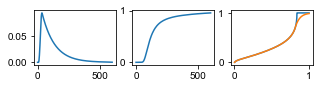

In [28]:
from prediction_functions import *

# constants
constants = get_constants(constants)
experiment_time = 600 # number of seconds

fig = plt.figure()
fig.set_figwidth(5)
fig.set_figheight(1)

# VELOCITY
dead_volume = 0.35 #mL
injection_duration = Injection_volume/Injection_rate*60 #s
velocity_peak = 0.1 #cm/s from Schlieren measurements
mean_free_path = np.sqrt(10)*12200e-6 #m NOT AT ALL SURE; MFP probably closer to 63nm
time_range = np.linspace(0,experiment_time,601)

velocity = calculate_velocity_profile(time_range, Injection_start_t, injection_duration, velocity_peak, constants["kinematic viscosity"], mean_free_path)
fig.add_subplot(131)
plt.plot(velocity);


# CONVECTION-DIFFUSION
x_range = np.linspace(0,sensor_separation_distance*1e-2 , 41)
y_width = 3.5 #cm

concentration, time = solve_convection_diffusion(x_range, velocity, time_range, constants, Injection_volume, y_width)
fig.add_subplot(132)
plt.plot(time,concentration);


# ADSORPTION
adsorption_isotherm_model = "ISF_4" # can be ISF_2, FHH, or ISF_4
h_range = np.linspace(0,sensor_pore_radius*10e-10 *1.05, 500)
isotherm_terminal_slope = 5
isotherm_correction = "exponential"

params = {"Pentane": [47.9e6, 3.38e-10, 59.5e6, 0.69e-10, 8.70, 1.79] # DBdB theory Pi1[Pa], lambda1[m], Pi2[Pa], lambda2[m]; FHH theory k,m (unitless)
         } # [2*47.9e6, .5*3.38e-10, .2*59.5e6, .5*0.69e-10, 8.70, 1.79]

isotherm_h, isotherm_P, critical_thickness  = calculate_partial_pressure_adsorption(h_range, sensor_pore_radius*1e-9, adsorption_isotherm_model, params[adsorption_parameters_for], constants)
isotherm_h_corrected, isotherm_P_corrected = apply_correction_to_isotherm(isotherm_P, isotherm_h, "exponential", isotherm_terminal_slope)

fig.add_subplot(133)
plt.plot(isotherm_P, isotherm_h);
plt.plot(isotherm_P_corrected, isotherm_h_corrected);

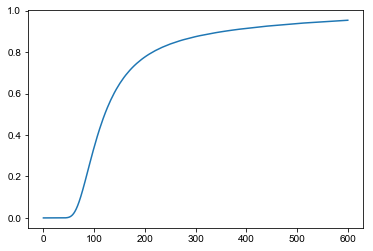

In [29]:
concentration, time = solve_convection_diffusion(x_range, velocity, time_range, constants, Injection_volume, y_width)
plt.plot(time, concentration)

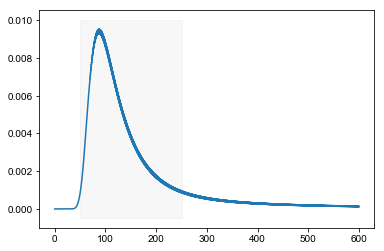

In [30]:
plt.plot(time[:-1], np.diff(concentration)/np.diff(time))
plt.fill_between([50, 250],[plt.ylim()[0]]*2,[plt.ylim()[1]]*2, color = (0.7, 0.7, 0.7), alpha=0.1)